# Regularization and Evaluation of Neural Networks

In [3]:
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.confusion import plot_confusion_matrix
    
%load_ext autoreload
%autoreload 2

## Learning Objectives

- use `keras` to code up a neural network model;
- explain dropout and early stopping as distinctive forms of regularization in neural networks;
- use wrappers inside `keras` to make models that can jibe with `sklearn`.

### From last time

In [22]:
digits = load_digits()
X = digits.data.astype('float32')
y = digits.target.astype('float32')

y_binary = y % 2

In [23]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X, y_binary, epochs=50, batch_size=10)

Epoch 1/50
180/180 [==============================] - 0s 581us/step - loss: 0.6168 - accuracy: 0.6722
Epoch 2/50
180/180 [==============================] - 0s 600us/step - loss: 0.2742 - accuracy: 0.8831
Epoch 3/50
180/180 [==============================] - 0s 650us/step - loss: 0.1911 - accuracy: 0.9232
Epoch 4/50
180/180 [==============================] - 0s 761us/step - loss: 0.1483 - accuracy: 0.9449
Epoch 5/50
180/180 [==============================] - 0s 583us/step - loss: 0.1241 - accuracy: 0.9516
Epoch 6/50
180/180 [==============================] - 0s 678us/step - loss: 0.1022 - accuracy: 0.9588
Epoch 7/50
180/180 [==============================] - 0s 594us/step - loss: 0.0840 - accuracy: 0.9688
Epoch 8/50
180/180 [==============================] - 0s 525us/step - loss: 0.0744 - accuracy: 0.9711
Epoch 9/50
180/180 [==============================] - 0s 539us/step - loss: 0.0642 - accuracy: 0.9750
Epoch 10/50
180/180 [==============================] - 0s 530us/step - loss: 0.055

### Things to know:

- The data and labels in `fit()` need to be numpy arrays, not `pandas` dfs.
- Scaling your data will have a large impact on your model.
   > For our traditional input features, we would use a scaler object. For images, as long as the minimum value is 0, we can simply divide through by the maximum pixel intensity.

#### Getting data ready for modeling

**Preprocessing**:

- use train_test_split to create X_train, y_train, X_test, and y_test
- Split training data into pure_train and validation sets.
- Scale the pixel intensity to a value between 0 and 1.

Scaling our input variables will help speed up our neural network.

Since our minimum intensity is 0, we can normalize the inputs by dividing each value by the max value (16).

In [25]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y_binary, random_state=42, test_size=0.2)

X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train, random_state=42, test_size=0.2)

X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

In [26]:
X_pure_train

array([[0.    , 0.    , 0.    , ..., 0.875 , 0.    , 0.    ],
       [0.    , 0.    , 0.125 , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.    , 0.375 , ..., 0.1875, 0.    , 0.    ],
       [0.    , 0.    , 0.625 , ..., 0.8125, 1.    , 0.5   ],
       [0.    , 0.    , 0.25  , ..., 0.0625, 0.    , 0.    ]],
      dtype=float32)

### Sigmoid 

For activation, let's start with the familiar sigmoid function, and see how it performs.

In [27]:
model = Sequential()
# We will start with our trusty sigmoid function.
# What does input dimension correspond to?
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
              # We use binary_crossentropy for a binary loss function
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output. To see
# only the metrics at the end of each epoch, set verbose=2.
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

Epoch 1/10
12/12 [==============================] - 0s 583us/step - loss: 0.6920 - accuracy: 0.5039
Epoch 2/10
12/12 [==============================] - 0s 833us/step - loss: 0.6919 - accuracy: 0.5039
Epoch 3/10
12/12 [==============================] - 0s 625us/step - loss: 0.6917 - accuracy: 0.5048
Epoch 4/10
12/12 [==============================] - 0s 792us/step - loss: 0.6916 - accuracy: 0.5039
Epoch 5/10
12/12 [==============================] - 0s 750us/step - loss: 0.6915 - accuracy: 0.5057
Epoch 6/10
12/12 [==============================] - 0s 583us/step - loss: 0.6914 - accuracy: 0.5057
Epoch 7/10
12/12 [==============================] - 0s 625us/step - loss: 0.6913 - accuracy: 0.5083
Epoch 8/10
12/12 [==============================] - 0s 542us/step - loss: 0.6912 - accuracy: 0.5109
Epoch 9/10
12/12 [==============================] - 0s 625us/step - loss: 0.6912 - accuracy: 0.5126
Epoch 10/10
12/12 [==============================] - 0s 667us/step - loss: 0.6911 - accuracy: 0.5170

We can access the history of our model via `results.history`.
Use __dict__ to take a tour.

In [28]:
# dict

results.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x26ed2ca1400>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.6919955611228943,
   0.6918622255325317,
   0.6917317509651184,
   0.6916241645812988,
   0.6915319561958313,
   0.6914480924606323,
   0.6913225054740906,
   0.691236138343811,
   0.6911607384681702,
   0.6910787224769592],
  'accuracy': [0.5039164423942566,
   0.5039164423942566,
   0.5047867894172668,
   0.5039164423942566,
   0.5056570768356323,
   0.5056570768356323,
   0.5082680583000183,
   0.5108790397644043,
   0.51261967420578,
   0.5169712901115417]},
 'params': {'verbose': 1, 'epochs': 10, 'steps': 12},
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [29]:
results.history

{'loss': [0.6919955611228943,
  0.6918622255325317,
  0.6917317509651184,
  0.6916241645812988,
  0.6915319561958313,
  0.6914480924606323,
  0.6913225054740906,
  0.691236138343811,
  0.6911607384681702,
  0.6910787224769592],
 'accuracy': [0.5039164423942566,
  0.5039164423942566,
  0.5047867894172668,
  0.5039164423942566,
  0.5056570768356323,
  0.5056570768356323,
  0.5082680583000183,
  0.5108790397644043,
  0.51261967420578,
  0.5169712901115417]}

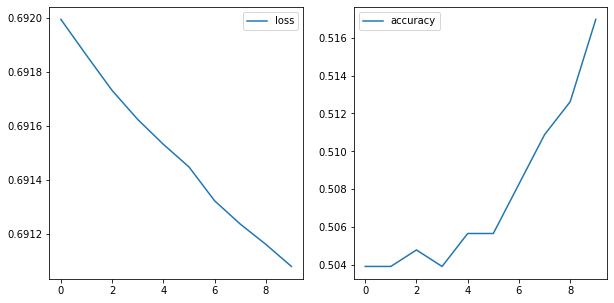

In [30]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

We have two plots above both relating to the quality of our model.  The left-hand plot is our loss. It uses the probabilities associated with our predictions to judge how well our prediction fits reality. We want it to decrease as far as possible.

The accuracy judges how well the predictions are after applying the threshold at the output layer.  We want accuracy to increase.

If we look at our loss, it is still decreasing. That is a signal that our model is **still learning**. If our model is still learning, we can allow it to get better by turning a few dials.

Let's:
- increase the number of epochs;
- change sigmoid activation in the hidden layers to ReLU; and
- decrease the batch size.

## Basic Model Tuning

### Increase Epochs

In [31]:
model = Sequential()
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
# increase epochs

results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=100, verbose=1)


Epoch 1/100
12/12 [==============================] - 0s 750us/step - loss: 0.7566 - accuracy: 0.4961
Epoch 2/100
12/12 [==============================] - 0s 792us/step - loss: 0.7458 - accuracy: 0.4961
Epoch 3/100
12/12 [==============================] - 0s 708us/step - loss: 0.7365 - accuracy: 0.4961
Epoch 4/100
12/12 [==============================] - 0s 583us/step - loss: 0.7292 - accuracy: 0.4961
Epoch 5/100
12/12 [==============================] - 0s 917us/step - loss: 0.7233 - accuracy: 0.4961
Epoch 6/100
12/12 [==============================] - 0s 625us/step - loss: 0.7185 - accuracy: 0.4961
Epoch 7/100
12/12 [==============================] - 0s 625us/step - loss: 0.7143 - accuracy: 0.4961
Epoch 8/100
12/12 [==============================] - 0s 583us/step - loss: 0.7110 - accuracy: 0.4961
Epoch 9/100
12/12 [==============================] - 0s 1ms/step - loss: 0.7085 - accuracy: 0.4961
Epoch 10/100
12/12 [==============================] - 0s 667us/step - loss: 0.7065 - accuracy

12/12 [==============================] - 0s 833us/step - loss: 0.6927 - accuracy: 0.5144
Epoch 82/100
12/12 [==============================] - 0s 583us/step - loss: 0.6926 - accuracy: 0.5126
Epoch 83/100
12/12 [==============================] - 0s 667us/step - loss: 0.6925 - accuracy: 0.5030
Epoch 84/100
12/12 [==============================] - 0s 1ms/step - loss: 0.6924 - accuracy: 0.5178
Epoch 85/100
12/12 [==============================] - 0s 542us/step - loss: 0.6924 - accuracy: 0.5187
Epoch 86/100
12/12 [==============================] - 0s 833us/step - loss: 0.6923 - accuracy: 0.5187
Epoch 87/100
12/12 [==============================] - 0s 833us/step - loss: 0.6922 - accuracy: 0.5222
Epoch 88/100
12/12 [==============================] - 0s 875us/step - loss: 0.6922 - accuracy: 0.5318
Epoch 89/100
12/12 [==============================] - 0s 708us/step - loss: 0.6921 - accuracy: 0.5292
Epoch 90/100
12/12 [==============================] - 0s 542us/step - loss: 0.6920 - accuracy: 0.

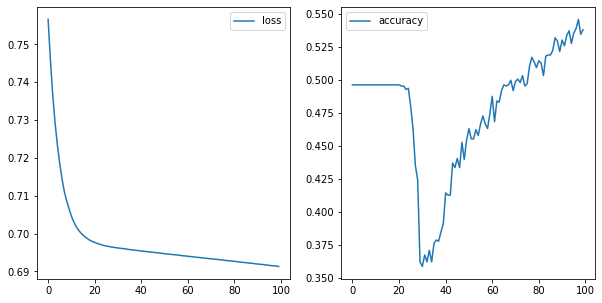

In [32]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Decrease Batch Size

In [33]:
model = Sequential()

model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# decrease batch size
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=None, verbose=0)

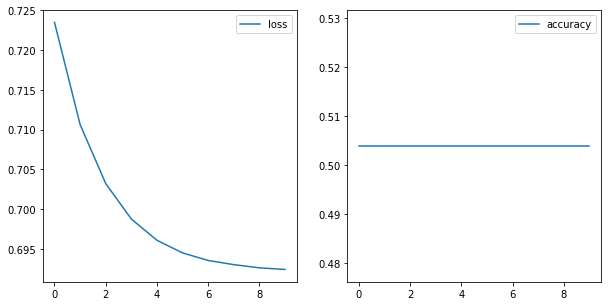

In [34]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Both

In [35]:
model = Sequential()

model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# increase epochs decrease batch size
results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=10, verbose=0)

Epoch 1/100
115/115 [==============================] - 0s 574us/step - loss: 0.7394 - accuracy: 0.5039
Epoch 2/100
115/115 [==============================] - 0s 522us/step - loss: 0.7006 - accuracy: 0.5039
Epoch 3/100
115/115 [==============================] - 0s 548us/step - loss: 0.6953 - accuracy: 0.5065
Epoch 4/100
115/115 [==============================] - 0s 535us/step - loss: 0.6936 - accuracy: 0.5187
Epoch 5/100
115/115 [==============================] - 0s 561us/step - loss: 0.6923 - accuracy: 0.5187
Epoch 6/100
115/115 [==============================] - 0s 652us/step - loss: 0.6913 - accuracy: 0.5448
Epoch 7/100
115/115 [==============================] - 0s 548us/step - loss: 0.6899 - accuracy: 0.5849
Epoch 8/100
115/115 [==============================] - 0s 535us/step - loss: 0.6886 - accuracy: 0.6005
Epoch 9/100
115/115 [==============================] - 0s 557us/step - loss: 0.6872 - accuracy: 0.5779
Epoch 10/100
115/115 [==============================] - 0s 552us/step - l

115/115 [==============================] - 0s 583us/step - loss: 0.3095 - accuracy: 0.8851
Epoch 80/100
115/115 [==============================] - 0s 517us/step - loss: 0.3064 - accuracy: 0.8842
Epoch 81/100
115/115 [==============================] - 0s 552us/step - loss: 0.3033 - accuracy: 0.8877
Epoch 82/100
115/115 [==============================] - 0s 570us/step - loss: 0.3002 - accuracy: 0.8886
Epoch 83/100
115/115 [==============================] - 0s 500us/step - loss: 0.2976 - accuracy: 0.8895
Epoch 84/100
115/115 [==============================] - 0s 583us/step - loss: 0.2947 - accuracy: 0.8903
Epoch 85/100
115/115 [==============================] - 0s 622us/step - loss: 0.2917 - accuracy: 0.8895
Epoch 86/100
115/115 [==============================] - 0s 522us/step - loss: 0.2893 - accuracy: 0.8921
Epoch 87/100
115/115 [==============================] - 0s 548us/step - loss: 0.2871 - accuracy: 0.8921
Epoch 88/100
115/115 [==============================] - 0s 552us/step - loss:

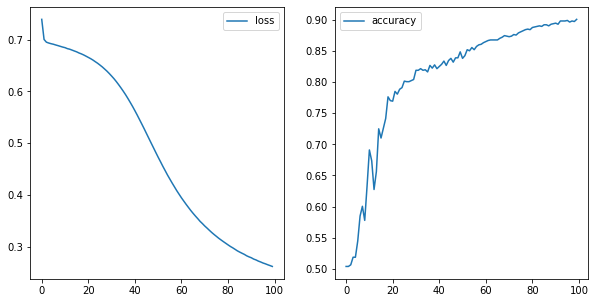

In [36]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Use Relu

In [39]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
# increase epochs, decrease batchsize

results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=0)


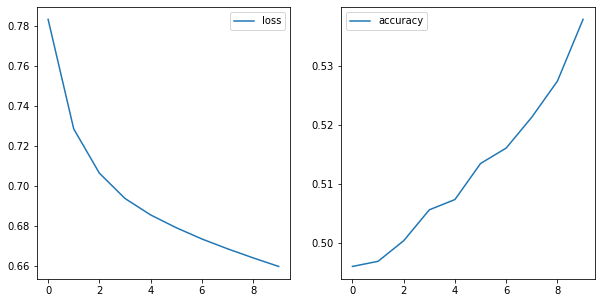

In [40]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### All of it (epochs, batch, relu)

In [45]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
# increase epochs


results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=10, verbose=0)

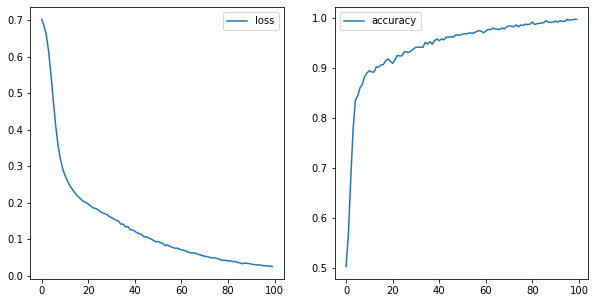

In [46]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Side note: learning rate

If we increase the learning rate to a very high number, we see that our model overshoots the minimum, and starts bouncing all around.

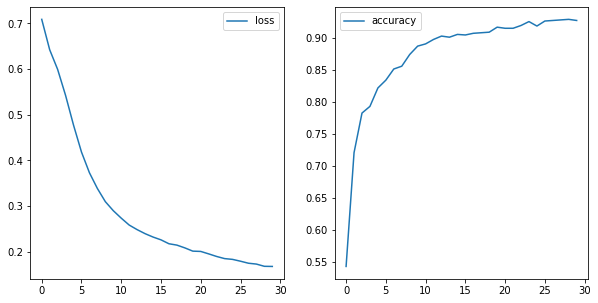

In [51]:
model = Sequential()

sgd = SGD(lr=.009)


model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                    epochs=30, batch_size=10, verbose=0)

relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();


### Exercise

We have been looking only at our training set. Let's add in our validation set to the picture. Check the docstring for the `.fit()` method and add in our validation data.

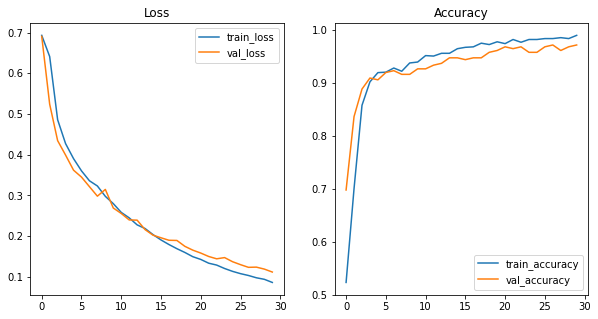

In [54]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


## YOUR CODE HERE

results = model.fit(
    X_pure_train, y_pure_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=10,
    verbose=0
)


train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [ ]:
results.history['val_accuracy'][-1]

## Connecting with `sklearn`

The `keras.wrappers` submodule means that we can turn `keras` models into estimators that `sklearn` tools will recognize.

In [55]:
# This will throw an error.

cross_val_score(model, X_pure_train, y_pure_train)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000026ED2843670> does not.

In [56]:
def build_model():
    model = Sequential()
    model.add(Dense(12, activation='relu', input_dim=64))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
scikit_learn.KerasRegressor()

In [64]:
keras_model = scikit_learn.KerasClassifier(build_model,
                                          epochs=10,
                                          batch_size=32,
                                          verbose=2)

In [65]:
type(keras_model)

tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier

In [66]:
cross_val_score(keras_model, X_pure_train, y_pure_train)

Epoch 1/10
29/29 - 0s - loss: 0.6729 - accuracy: 0.4929
Epoch 2/10
29/29 - 0s - loss: 0.6339 - accuracy: 0.5190
Epoch 3/10
29/29 - 0s - loss: 0.5809 - accuracy: 0.6202
Epoch 4/10
29/29 - 0s - loss: 0.5315 - accuracy: 0.7639
Epoch 5/10
29/29 - 0s - loss: 0.4966 - accuracy: 0.8281
Epoch 6/10
29/29 - 0s - loss: 0.4726 - accuracy: 0.8640
Epoch 7/10
29/29 - 0s - loss: 0.4527 - accuracy: 0.8770
Epoch 8/10
29/29 - 0s - loss: 0.4372 - accuracy: 0.8770
Epoch 9/10
29/29 - 0s - loss: 0.4222 - accuracy: 0.8955
Epoch 10/10
29/29 - 0s - loss: 0.4087 - accuracy: 0.8966
8/8 - 0s - loss: 0.3908 - accuracy: 0.9000
Epoch 1/10
29/29 - 0s - loss: 0.6756 - accuracy: 0.5876
Epoch 2/10
29/29 - 0s - loss: 0.5973 - accuracy: 0.7802
Epoch 3/10
29/29 - 0s - loss: 0.5126 - accuracy: 0.8596
Epoch 4/10
29/29 - 0s - loss: 0.4406 - accuracy: 0.8738
Epoch 5/10
29/29 - 0s - loss: 0.3772 - accuracy: 0.9053
Epoch 6/10
29/29 - 0s - loss: 0.3252 - accuracy: 0.9217
Epoch 7/10
29/29 - 0s - loss: 0.2912 - accuracy: 0.9195
Epoc

array([0.89999998, 0.93913043, 0.90869564, 0.94782609, 0.85589522])

## [Regularization](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer)

Does regularization make sense in the context of neural networks? <br/>

Yes! We still have all of the salient ingredients: a loss function, overfitting vs. underfitting, and coefficients (weights) that could get too large.

But there are now a few different flavors besides L1 and L2 regularization. (Note that L1 regularization is not common in the context of  neural networks.)

We'll add a few more layers to give regularization a better chance of making a difference!

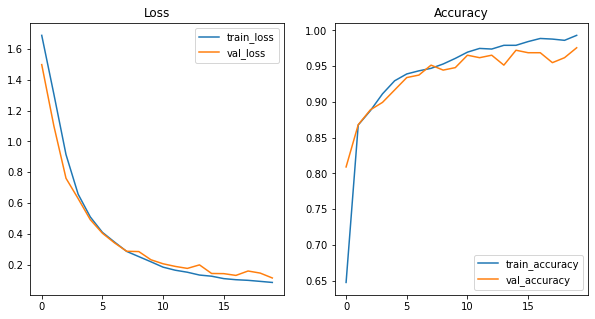

In [73]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))

# We can add L2 (or L1) regularization right into
# the layer with the kernel_regularizer parameter.

model.add(Dense(20, activation='relu',kernel_regularizer=l2(l=.05)))

# Note that there is also a bias_regularizer,
# but this tends to have less effect.

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

Adding L2 to multiple layers:

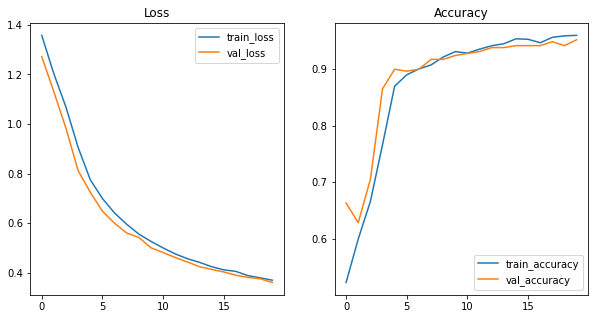

In [68]:
model = Sequential()
model.add(Dense(30, activation='relu',
                input_dim=64))
model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l=0.01)))

model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(8, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(4, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

### Dropout

We can also specify a dropout layer in keras, which randomly shuts off different nodes during training. This can help to prevent overfitting.

![drop_out](images/drop_out.png)

### Exercise

To add dropout to a `keras` network, simply add it as though it were a layer. It will apply to the immediately preceding layer.

Add Dropout to one or more layers below.

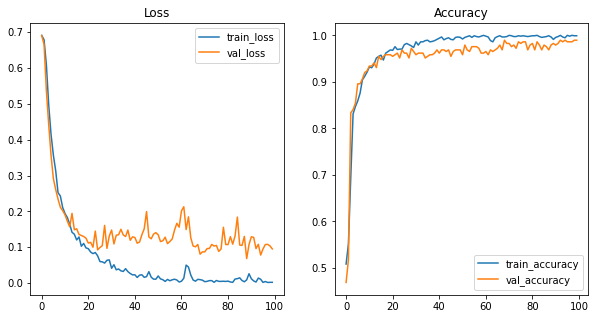

In [85]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=100,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [84]:
results.history['val_accuracy'][-1]

0.9583333134651184

### Early Stopping

We can also tell our neural network to stop once it stops realizing any gain.

Here we tell it to stop once the a very small positive change in the validation loss occurs:

Epoch 00008: early stopping


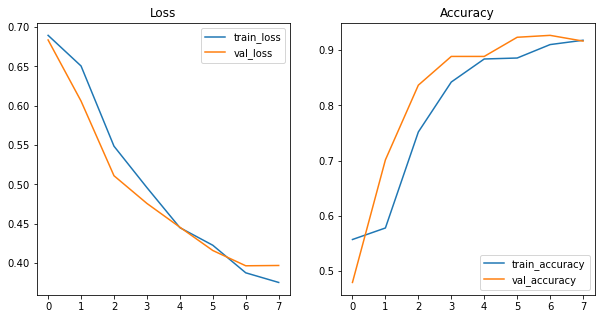

In [86]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

### Exercise

That probably stopped too early. We can specify the number of epochs in which it doesn't see decrease in the loss with the `patience` parameter. Modify the code below to include an Early Stop with a patience of 5 epochs.

Epoch 00034: early stopping


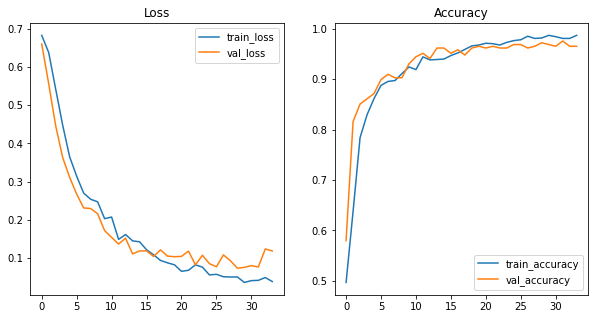

In [93]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1,
                           patience=5,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [94]:
results.history['val_accuracy'][-1]

0.9652777910232544

## Multiclass Classification and Softmax

Now let's return to the problem of predicting digits 0 through 9.

In [95]:
digits = load_digits()
X = digits.data
y = digits.target

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train,
                     random_state=42, test_size=0.2)
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For a multiclass output, our neural net expects our target to be in a certain form.

In [97]:
ohe = OneHotEncoder(sparse=False)
y_pure_train = ohe.fit_transform(y_pure_train.reshape(-1,1))
y_val = ohe.transform(y_val.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [98]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [99]:
y_test.shape

(360, 10)

In [100]:
# Model from above, but now with ten output neurons:

model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                   epochs=50, batch_size=10,
                   validation_data=(X_val, y_val))

Epoch 1/50
115/115 [==============================] - 0s 2ms/step - loss: 2.2461 - accuracy: 0.1723 - val_loss: 2.1685 - val_accuracy: 0.2049
Epoch 2/50
115/115 [==============================] - 0s 804us/step - loss: 2.0236 - accuracy: 0.2924 - val_loss: 1.8752 - val_accuracy: 0.3264
Epoch 3/50
115/115 [==============================] - 0s 835us/step - loss: 1.6524 - accuracy: 0.4621 - val_loss: 1.5101 - val_accuracy: 0.4583
Epoch 4/50
115/115 [==============================] - 0s 1ms/step - loss: 1.2876 - accuracy: 0.6179 - val_loss: 1.2228 - val_accuracy: 0.6042
Epoch 5/50
115/115 [==============================] - 0s 809us/step - loss: 1.0491 - accuracy: 0.7023 - val_loss: 1.0251 - val_accuracy: 0.7188
Epoch 6/50
115/115 [==============================] - 0s 761us/step - loss: 0.8948 - accuracy: 0.7633 - val_loss: 0.8855 - val_accuracy: 0.7674
Epoch 7/50
115/115 [==============================] - 0s 800us/step - loss: 0.7754 - accuracy: 0.8059 - val_loss: 0.7952 - val_accuracy: 0.7

$$\large \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

The sofmax function outputs a number between 0 and 1 for each of our classes.  All of the probabilities of the classes sum up to 1.

The number of nodes in our output layer equals the number of categories in our dataset.

We also need a new loss function: **categorical crossentropy**, which calculates a separate loss for each label and then sums the results.

In [101]:
history = results.history
training_loss = history['loss']
val_loss = history['val_loss']
training_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

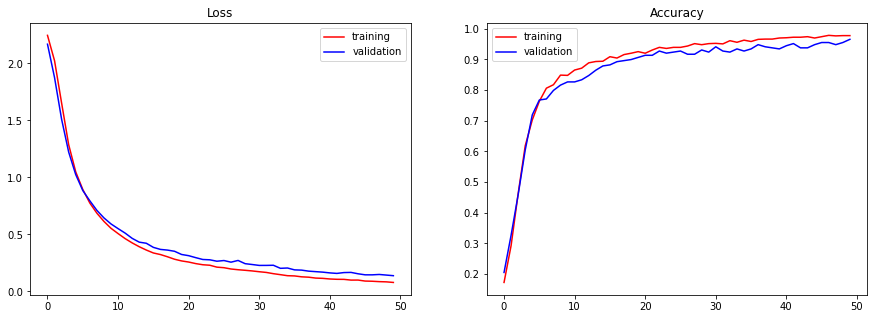

In [102]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x=list(range(len(training_loss))),
             y=training_loss, color='r', label='training', ax=ax1)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_loss, color='b', label='validation', ax=ax1)
sns.lineplot(x=list(range(len(training_loss))),
             y=training_accuracy, color='r', label='training',ax=ax2)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_accuracy, color='b', label='validation',ax=ax2)

ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [103]:
history['val_accuracy'][-1]

0.9652777910232544

In [104]:
history['accuracy'][-1]

0.9773716330528259

In [112]:
np.argmax(model.predict(X_test)[0])

6

In [110]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

Wow, look at that performance!  

That is great, but remember, we were dealing with simple black and white images.  With color, our basic neural net will have less success.

We will explore more advanced tools in the coming days.
